# Batch Analysis with Pykrev

In this tutorial we will look at how to analyse many spectra at once with PyKrev. The spectra we will look at were acquired on a 12T Bruker Solarix. 
There are 18 spectra in total, comprising triplicate dissolved organic matter samples at three depths extracted using two methods, Rhizon sampler or squeezing. (3 * 3 * 2 = 18).
They were processed using corems and each spectrum was written to an individual .csv file. 

In [1]:
# First import the libraries that we need. 
import pykrev as pk
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import seaborn as sns

In [2]:
#change to the data directory , run only once
os.chdir('../example_data/batch_analysis')

In [3]:
#save the sample names and sample paths as a list
sampleNames = [f.split('.')[0] for f in os.listdir() if f.endswith('csv') and 'PW' in f]
samplePaths = [f for f in os.listdir() if f.endswith('csv') and 'PW' in f]

The core data structure for batch analysis is the msTupleDict. This is a dictionary with spectrum names as keys and corresponding msTuples as values. Below we read each spectrum using pk.read_corems into an msTuple and store that tuple in msTupleDict.

In [4]:
analysisDict = pk.msTupleDict()

In [5]:
for name,path in zip(sampleNames,samplePaths):
    corems = pd.read_csv(path)
    analysisDict[name] = pk.read_corems(corems)

msTupleDicts have a variety of inbuilt methods. .summary() allows you to view a summary of the contents of the msTupleDict

In [6]:
analysisDict.summary()

msTupleDict containing 18 samples.

10_PW1_i summary
********************
assigned formula = 3079 
min intensity = 3.6E+06
max intensity = 5.4E+09
mean mz = 358.3093426023937 
std mz = 1.0E+02

10_PW1_ii summary
********************
assigned formula = 2998 
min intensity = 3.6E+06
max intensity = 5.8E+09
mean mz = 355.4160268374991 
std mz = 1.0E+02

10_PW1_iii summary
********************
assigned formula = 2902 
min intensity = 3.7E+06
max intensity = 5.9E+09
mean mz = 353.74477039756374 
std mz = 1.0E+02

10_PW2_i summary
********************
assigned formula = 2784 
min intensity = 3.7E+06
max intensity = 8.3E+09
mean mz = 351.8640426724465 
std mz = 1.0E+02

10_PW2_ii summary
********************
assigned formula = 2595 
min intensity = 4.1E+06
max intensity = 9.0E+09
mean mz = 349.1171574189941 
std mz = 1.0E+02

10_PW2_iii summary
********************
assigned formula = 2686 
min intensity = 4.0E+06
max intensity = 9.0E+09
mean mz = 350.41980567605805 
std mz = 1.0E+02

20_PW1_i

Another important inbuilt method is to_DataFrame() this writes the contents of the msTuple into a pandas dataframe that can be used as the basis for batch analysis

In [7]:
analysisDf = analysisDict.to_DataFrame()
analysisDf.head()

,assigned formula,mean mz,std mz
10_PW1_i,3079.0,358.309343,104.674672
10_PW1_ii,2998.0,355.416027,103.281716
10_PW1_iii,2902.0,353.744770,102.546840
10_PW2_i,2784.0,351.864043,102.701765
10_PW2_ii,2595.0,349.117157,101.262775


As it stands the analysis dataframe doesn't present a lot of options for analysis. We can change this by adding in more columns. To begin with we can add important sample metadata. 

In [8]:
#Add sample metadata
extraction = []
depths = []
for name in sampleNames:
    depth = name.split('_')[0]
    depths.append(int(depth))
    if 'PW1' in name:
        extraction.append('Rhizon')
    elif 'PW2' in name:
        extraction.append('Squeeze')

analysisDf['depth'] = pd.Categorical(depths)
analysisDf['extraction'] = pd.Categorical(extraction)

In [9]:
analysisDf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, 10_PW1_i to 45_PW2_iii
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   assigned formula  18 non-null     float64 
 1   mean mz           18 non-null     float64 
 2   std mz            18 non-null     float64 
 3   depth             18 non-null     category
 4   extraction        18 non-null     category
dtypes: category(2), float64(3)
memory usage: 1.4+ KB


Now we can add in useful information such as mean element counts and diversity metrics.

In [10]:
#Add information about mean element counts
C = []
H = []
N = []
O = []
intense = []
stdIntensity = []
for name in sampleNames:
    msTuple = analysisDict[name]
    elementDict = pk.element_counts(msTuple)
    elementData = pd.DataFrame(elementDict)
    C.append(np.mean(elementData['C']))
    H.append(np.mean(elementData['H']))
    N.append(np.mean(elementData['N']))
    O.append(np.mean(elementData['O']))

analysisDf['mean C'] = C
analysisDf['mean H'] = H
analysisDf['mean N'] = N
analysisDf['mean O'] = O


In [11]:
#Add information about sample diversity
simpson = []
shannon = []
for name in sampleNames:
    sampleTuple  = analysisDict[name]
    diversityDict = pk.diversity_indices(sampleTuple, verbose='False', indices = ['SW', 'GS'])
    simpson.append(diversityDict['D_a_GS'])
    shannon.append(diversityDict['D_a_SW'])
analysisDf['simpson'] = simpson
analysisDf['shannon'] = shannon

We can then make plots comparing spectra using the seaborn python library.

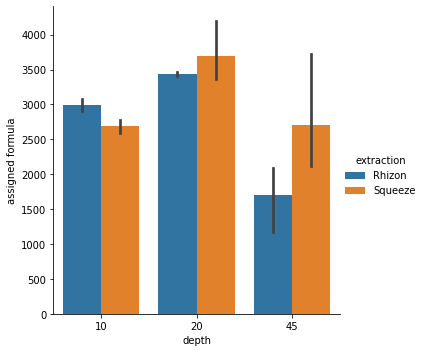

In [12]:
ax = sns.catplot(x="depth", y="assigned formula", hue="extraction", kind="bar", data=analysisDf)

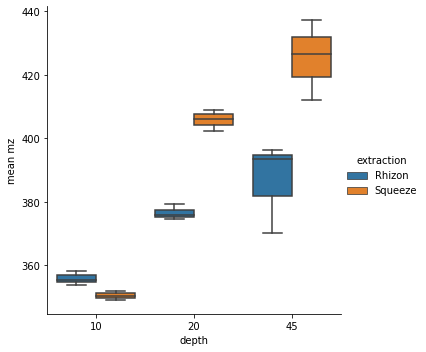

In [13]:
ax = sns.catplot(x="depth", y="mean mz", hue="extraction", kind="box", data=analysisDf)

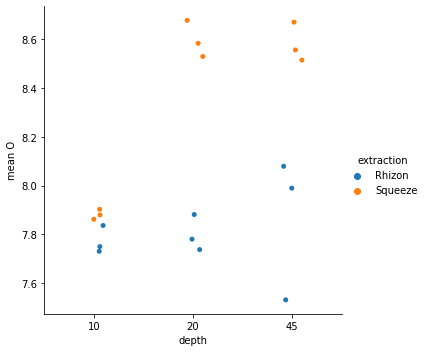

In [14]:
ax = sns.catplot(x="depth", y="mean O", hue="extraction", kind="strip", data=analysisDf)

Another type of analysis we may want to do is ordination and PCA. This is made relatively simple using the .to_OrdinationMatrix method of the msTupleDict. If you want more indepth instructions for PCA analysis in PyKrev, see the additional tutorial.

In [15]:
OrdinationMatrix = analysisDict.to_OrdinationMatrix(impute_value = 0)

In [16]:
NormMatrix = pk.normalise_intensity(OrdinationMatrix, norm_method = 'sum', norm_direction = 'rows') #row normalise by sum
NormMatrix = pk.normalise_intensity(NormMatrix, norm_method = 'center', norm_transform = 'power3', norm_direction = 'columns') #column normalise by cube root transform and scaling

In [17]:
from sklearn.decomposition import PCA

In [18]:
pca = PCA() #instance of the PCA class, here we can define parameters about the PCA 
pca.fit(NormMatrix) #fit the PCA intialised with default parameters to our data
pca_result = pca.transform(NormMatrix) # transform our data with the fitted model

In [19]:
analysisDf['PC1'] = pca_result[:,0]
analysisDf['PC2'] = pca_result[:,1]

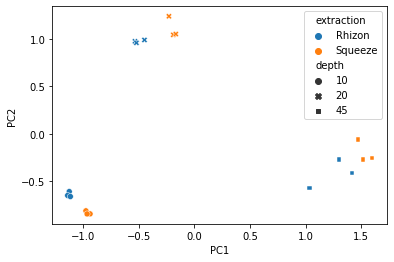

In [20]:
ax = sns.scatterplot(x="PC1", y="PC2", style = 'depth', hue="extraction", data=analysisDf)

In this example there are three technical replicates for each sample type. Using the msTupleDict.subset() and msTupleDict.average() methods it is possible to visualise the deviation between the replicates and produce an average msTuple.

msTupleDict containing 3 samples.

10_PW1_i summary
********************
assigned formula = 3079 
min intensity = 3.6E+06
max intensity = 5.4E+09
mean mz = 358.3093426023937 
std mz = 1.0E+02

10_PW1_ii summary
********************
assigned formula = 2998 
min intensity = 3.6E+06
max intensity = 5.8E+09
mean mz = 355.4160268374991 
std mz = 1.0E+02

10_PW1_iii summary
********************
assigned formula = 2902 
min intensity = 3.7E+06
max intensity = 5.9E+09
mean mz = 353.74477039756374 
std mz = 1.0E+02

average summary
********************
assigned formula = 2982 
min intensity = 3.6E+06
max intensity = 5.7E+09
mean mz = 355.66832813149034 
std mz = 1.0E+02


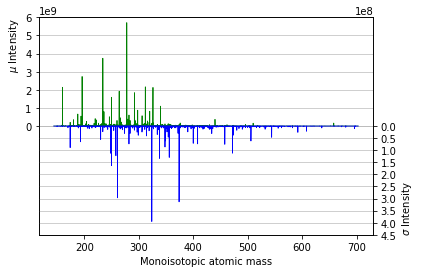

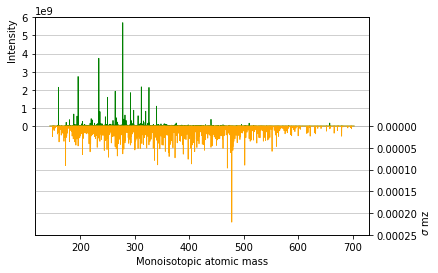

In [21]:
#To extract replicates from the analysisDict, we first pass a list of the replicate names to msTupleDict.subset()
replicateDict =  analysisDict.subset(subsetList=['10_PW1_i','10_PW1_ii','10_PW1_iii'])
replicateDict.summary()
#We can then average the spectra in the replicate dictionary using msTupleDict.average() for more info on this method see pk.average_mstuple
## Passing stdDev= TRUE will report the standard deviations for the intensity and mass 
## Setting minOccurrence to 2 will only include formula present in at least two samples
## Setting zeroValues to false will not include zero intensities in averaging
averageTuple, stdStats = replicateDict.average(intensityMethod = 'mean', mzMethod= 'mean', stdDev = True, minOccurrence = 2, zeroValues = False)
stdI = stdStats[0]
stdMz = stdStats[1]
print('average summary')
print('********************')
averageTuple.summary()
#Finally we can view the deviation in mass and intensity in the samples using pk.mass_spectrum
fig,ax1,ax2 = pk.mass_spectrum(averageTuple, invertedAxis = stdI, invertedAxisLabel = '$\sigma$ Intensity', stepSize = 3)
ax1.set_ylabel('$\mu$ Intensity')
plt.savefig('inverted_spectrum.png',dpi = 300)
fig,ax1,ax2 = pk.mass_spectrum(averageTuple, invertedAxis = stdMz, invertedAxisLabel = '$\sigma$ mz', invertedAxisColor = 'orange', stepSize= 3)
#you can write an msTuple to a .csv file using the .to_csv method
#averageTuple.to_csv('./average_tuple.csv')

That's the end of the batch analysis tutorial.